# Viewing inputs and outputs

In [ ]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In this tutorial, we'll see how the same API allows you to get a look at the inputs and outputs of your model, whether in the vision, text or tabular application. We'll go over a lot of different tasks and each time, grab some data in a [`DataBunch`](/basic_data.html#DataBunch) with the [data block API](/data_block.html), see how to get a look at a few inputs with the `show_batch` method, train an appropriate [`Learner`](/basic_train.html#Learner) then use the `show_results` method to see what the outputs of our model actually look like.

In [ ]:
jekyll_note("""As usual, this page is generated from a notebook that you can find in the docs_src folder of the
[fastai repo](https://github.com/fastai/fastai). The examples are all designed to run fast, which is why we use
samples of the dataset, a resnet18 as a backbone and don't train for very long. You can change all of those parameters
to run your own experiments!
""")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>As usual, this page is generated from a notebook that you can find in the docs_src folder of the
[fastai repo](https://github.com/fastai/fastai). The examples are all designed to run fast, which is why we use
samples of the dataset, a resnet18 as a backbone and don't train for very long. You can change all of those parameters
to run your own experiments!
</div>

## Vision

To quickly get access to all the vision functions inside fastai, we use the usual import statements.

In [ ]:
from fastai.vision import *

### A classification problem

Let's begin with our sample of the MNIST dataset.

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)

It's set up with an imagenet structure so we use it to load our training and validation datasets, then label, transform, convert them into ImageDataBunch and finally, normalize them.

In [ ]:
data = (ImageItemList.from_folder(mnist)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats))

Once your data is properly set up in a [`DataBunch`](/basic_data.html#DataBunch), we can call `data.show_batch()` to see what a sample of a batch looks like.

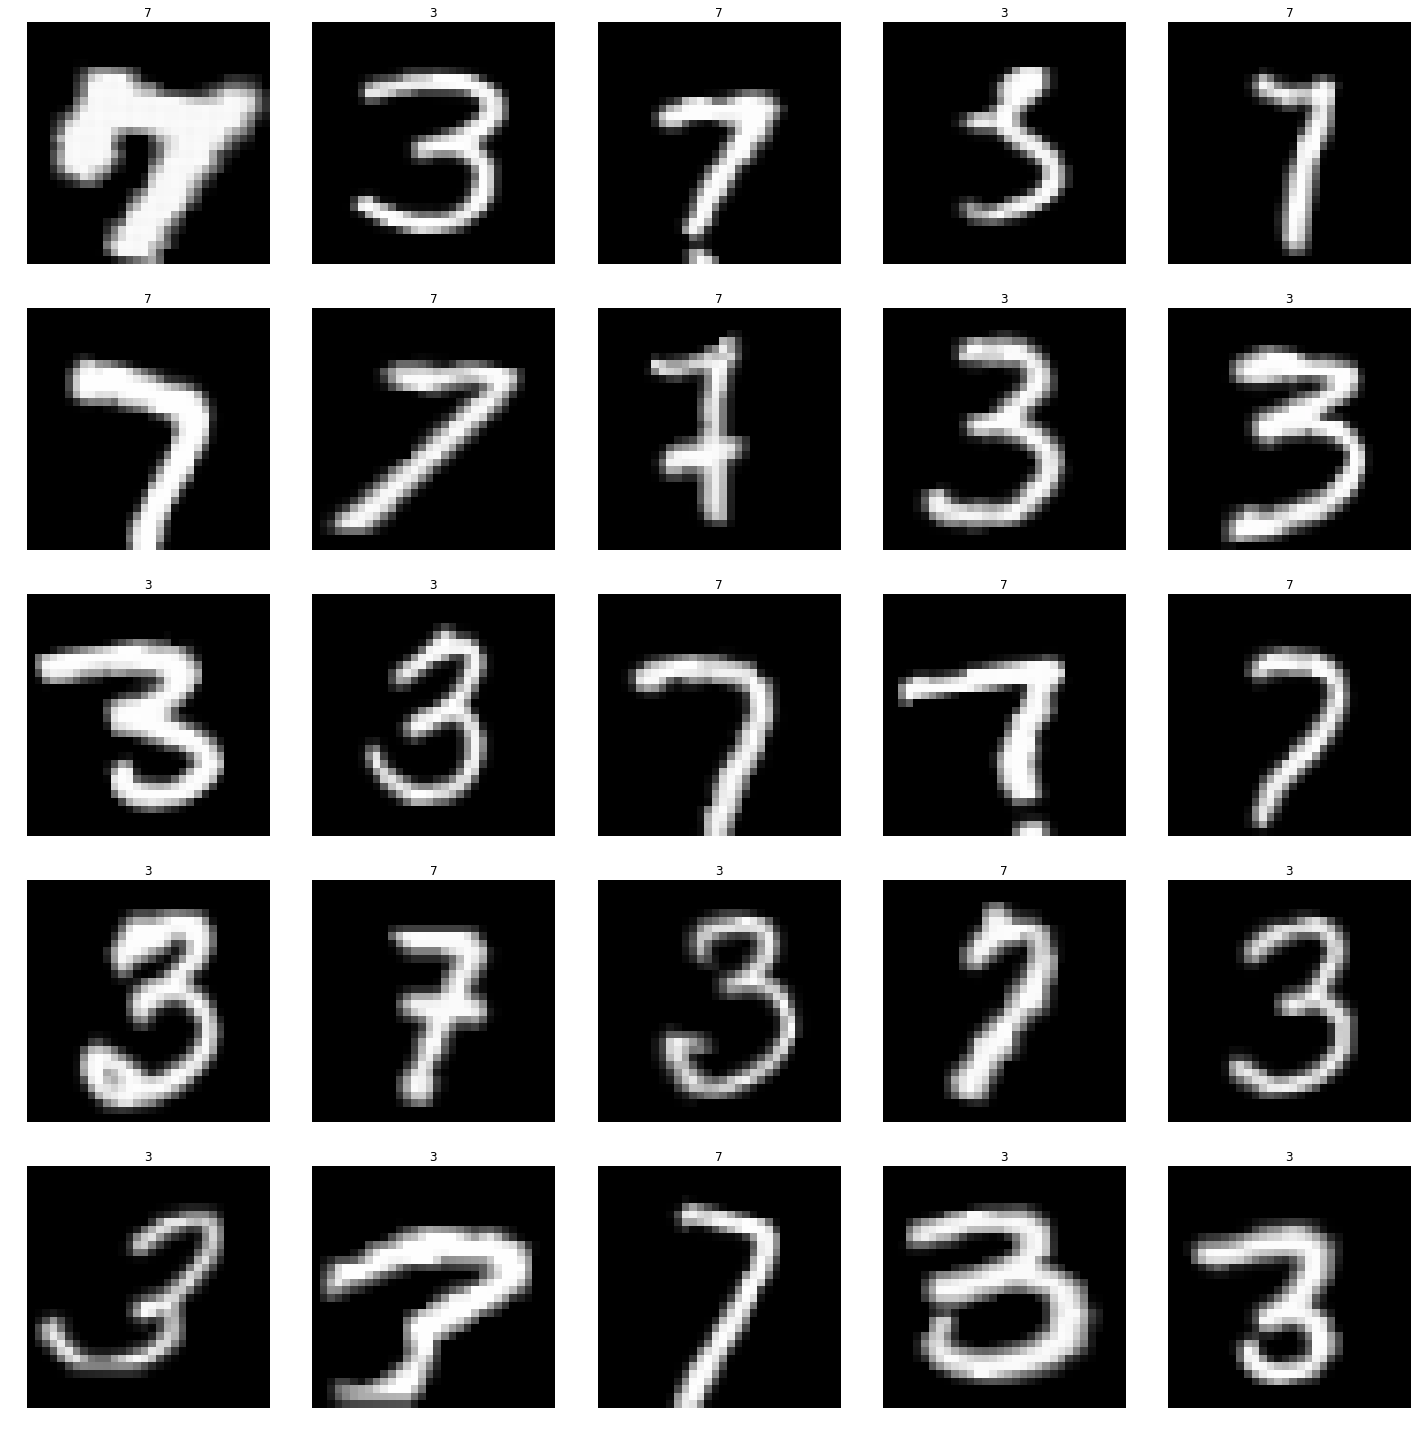

In [ ]:
data.show_batch()

Note that the images were automatically de-normalized before being showed with their labels (inferred from the names of the folder). We can specify a number of rows if the default of 5 is too big, and we can also limit the size of the figure.

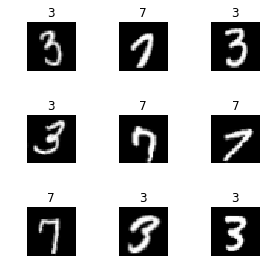

In [ ]:
data.show_batch(rows=3, figsize=(4,4))

Now let's create a [`Learner`](/basic_train.html#Learner) object to train a classifier.

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,accuracy
1,0.551465,0.365588,0.842632


Our model has quickly reached around 74% accuracy, now let's see its predictions on a sample of the validation set. For this, we use the `show_results` method.

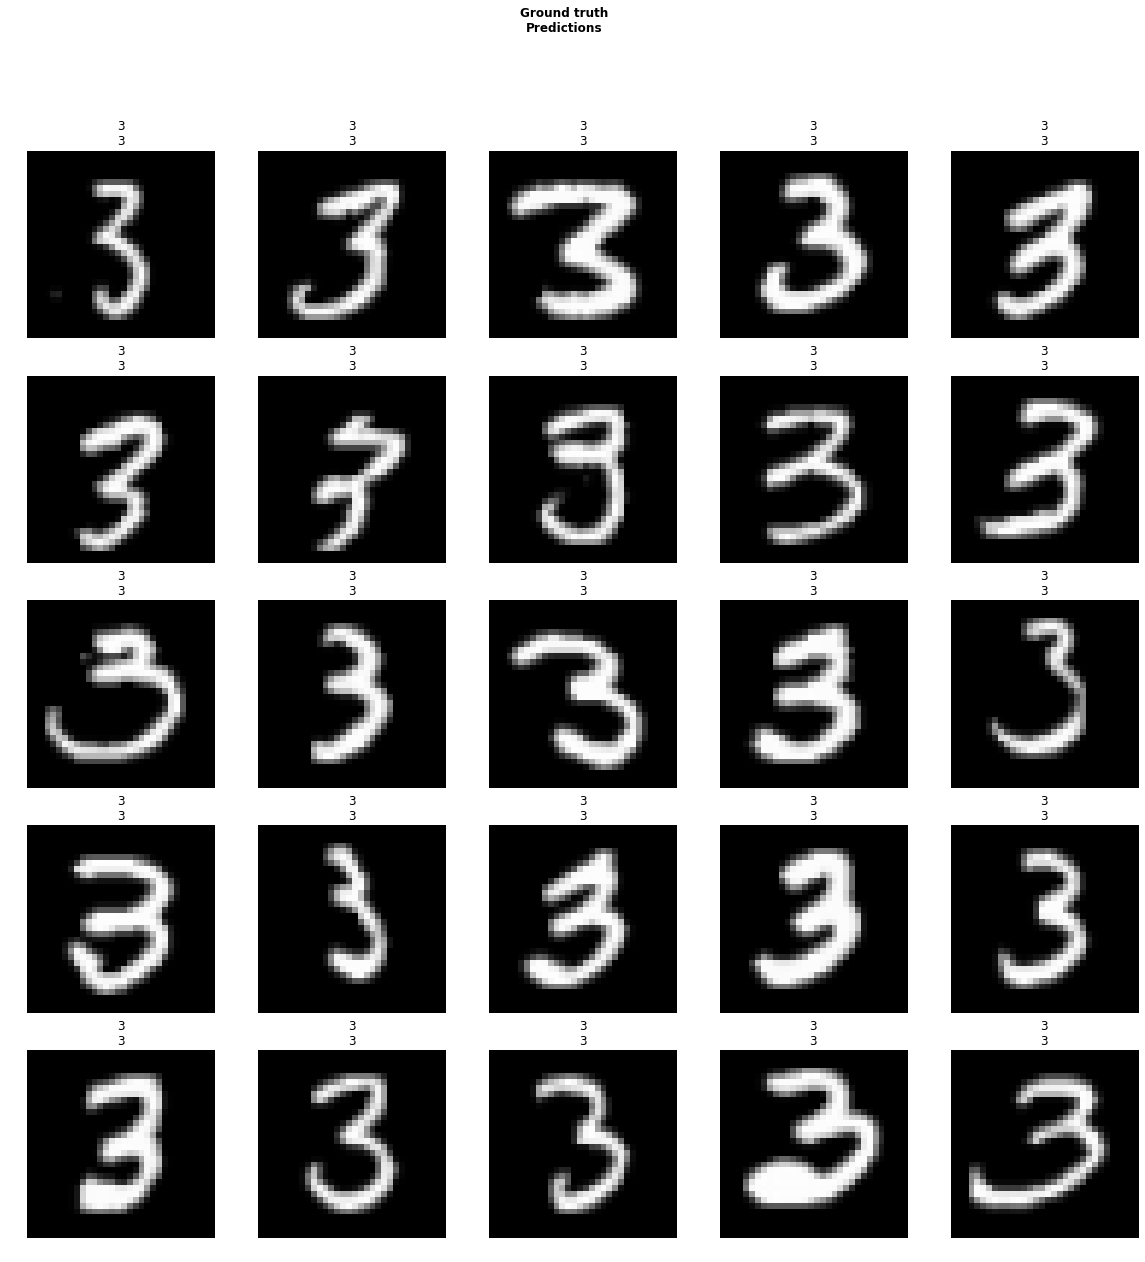

In [ ]:
learn.show_results()

Since the validation set is usually sorted, we get only images belonging to the same class. We can then again specify a number of rows, a figure size, but also the dataset on which we want to make predictions.

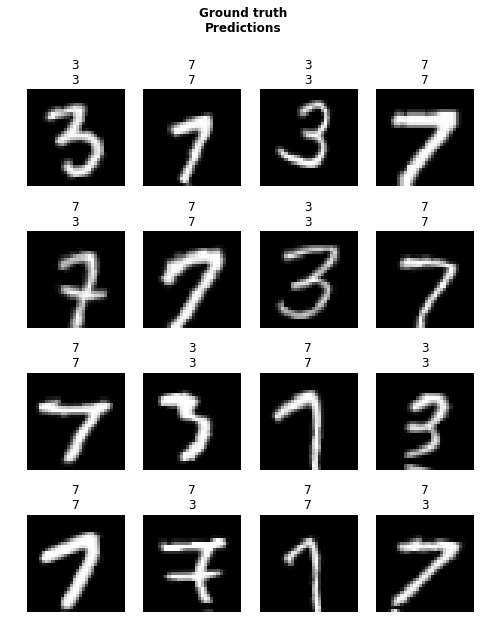

In [ ]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

### A multilabel problem

Now let's try these on the planet dataset, which is a little bit different in the sense that each image can have multiple tags (and not just one label).

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Here each images is labelled in a file named 'labels.csv'. We have to add 'train' as a prefix to the filenames, '.jpg' as a suffix and he labels are separated by spaces.

In [ ]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

And we can have look at our data with `data.show_batch`.

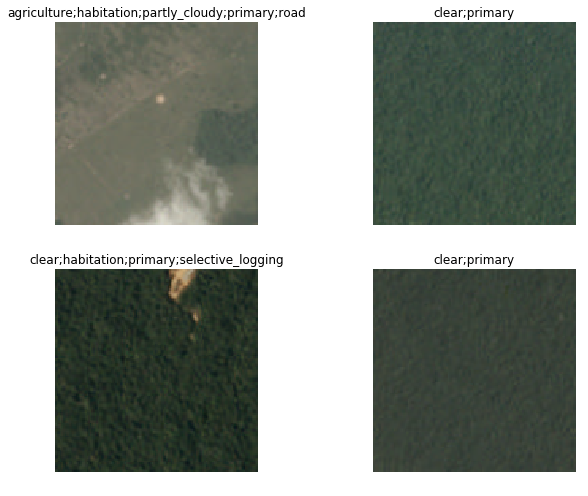

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

Then we can then create a [`Learner`](/basic_train.html#Learner) object pretty easily and train it for a little bit.

In [ ]:
learn = create_cnn(data, models.resnet18)
learn.fit_one_cycle(5,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss
1,0.832679,0.784007
2,0.792835,0.747330
3,0.734742,0.657603
4,0.687754,0.590955
5,0.647987,0.534690


And to see actual predictions, we just have to run `learn.show_results()`.

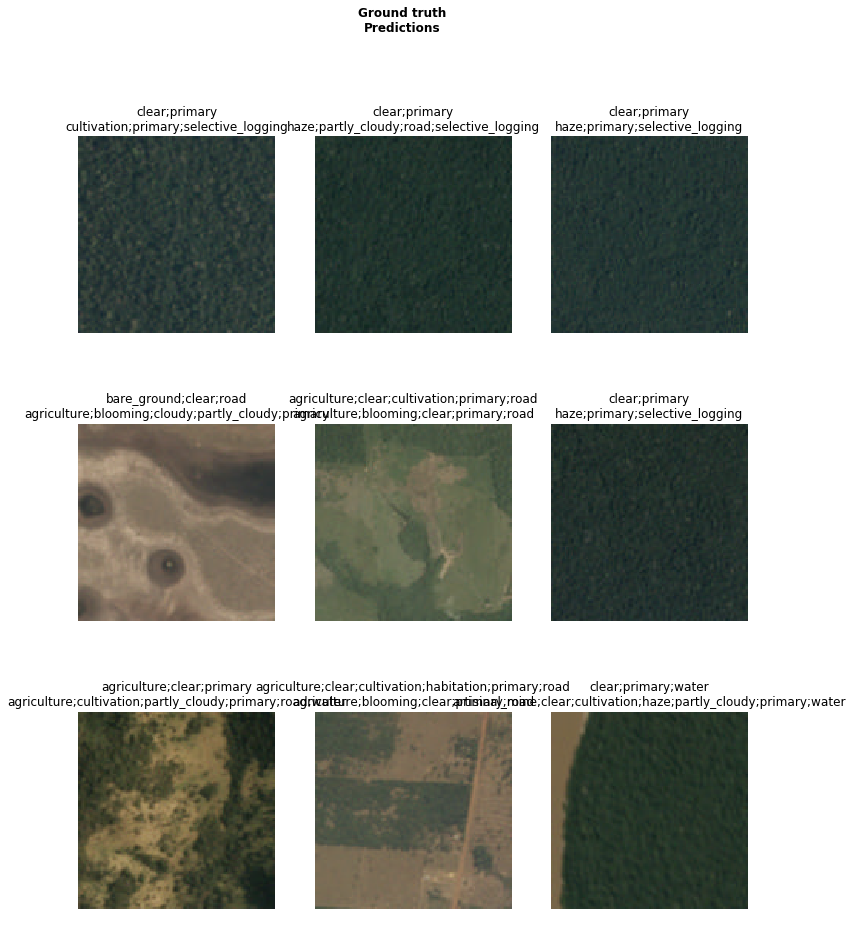

In [ ]:
learn.show_results(rows=3, figsize=(12,15))

### A regression example

For the next example, we are going to use the [BIWI head pose](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) dataset. On pictures of persons, we have to find the center of their face. For the fastai docs, we have built a small subsample of the dataset (200 images) and prepared a dictionary for the correspondance fielname to center.

In [ ]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

To grab our data, we use this dictionary to label our items. We also use the [`PointsItemList`](/vision.data.html#PointsItemList) class to have the targets be of type [`ImagePoints`](/vision.image.html#ImagePoints) (which will make sure the data augmentation is properly applied to them). When calling [`transform`](/tabular.transform.html#tabular.transform) we make sure to set `tfm_y=True`.

In [ ]:
data = (PointsItemList.from_folder(biwi)
        .random_split_by_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats))

Then we can have a first look at our data with `data.show_batch()`.

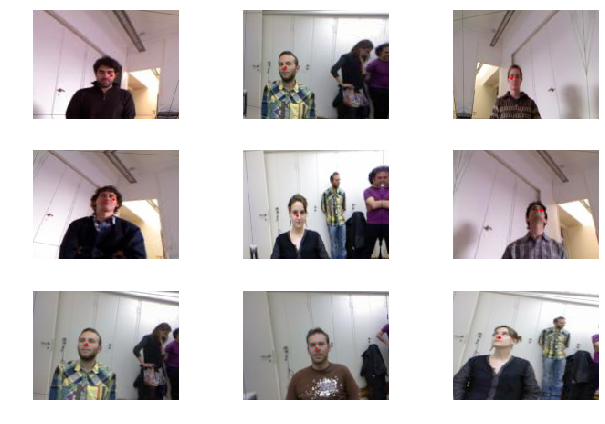

In [ ]:
data.show_batch(rows=3, figsize=(9,6))

We train our model for a little bit before using `learn.show_results()`.

In [ ]:
learn = create_cnn(data, models.resnet18, lin_ftrs=[100], ps=0.05)
learn.fit_one_cycle(5, 5e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss
1,0.644592,1.391604
2,0.868283,1.784884
3,0.694549,1.848114
4,0.540707,0.110488
5,0.438480,0.174414


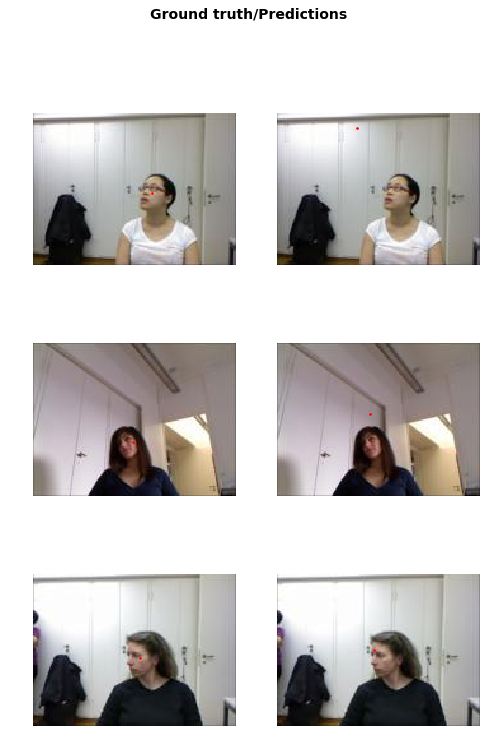

In [ ]:
learn.show_results(rows=3)

### A segmentation example

Now we are going to look at the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) (at least a small sample of it), where we have to predict the class of each pixel in an image. Each image in the 'images' subfolder as an equivalent in 'labels' that is its segmentations mask.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We read the classes in 'codes.txt' and the function maps each image filename with its corresponding mask filename.

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

The data block API allows us to uickly get everything in a [`DataBunch`](/basic_data.html#DataBunch) and then we can have a look with `show_batch`.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

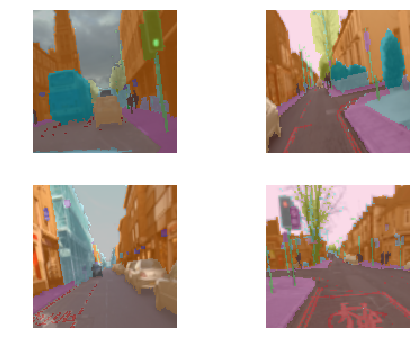

In [ ]:
data.show_batch(rows=2, figsize=(7,5))

Then we train a Unet for a few epochs.

In [ ]:
jekyll_warn("This training is fairly unstable, you should use more epochs and the full dataset to get better results.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This training is fairly unstable, you should use more epochs and the full dataset to get better results.</div>

In [ ]:
learn = unet_learner(data, models.resnet18)
learn.fit_one_cycle(3,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss
1,8.241356,2.770800
2,5.423615,2.000265
3,4.159805,1.892953


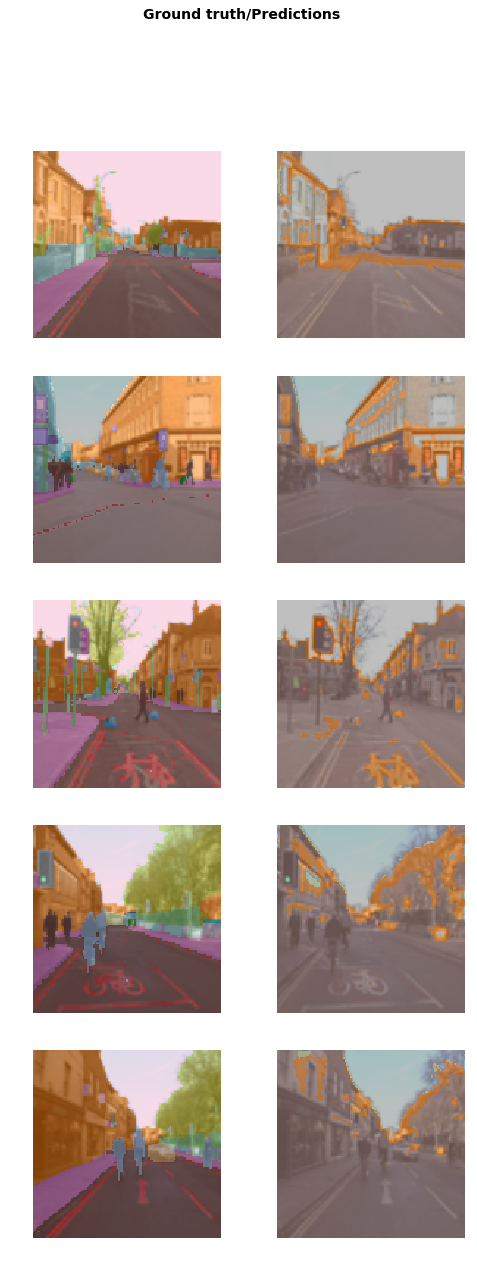

In [ ]:
learn.show_results()

## Text

Next application is text, so let's start by importing everything we'll need.

In [ ]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .random_split_by_pct()
                   .label_for_lm()
                   .databunch())
data_lm.save()

`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [ ]:
data_lm.show_batch()

idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,"and it is indeed a grand xxunk for the audience as well as the two principals . xxmaj the imagery throughout is impressive , especially the final scenes in xxmaj xxunk . xxmaj it xxunk for me once again how much different the world can be , but also at the same time , how similar . xxmaj the same was true for the father and son in this film"
2,"and 60 's , and as such , it 's a xxunk entertaining movie . xxmaj that sequence with the nurse is simply hilarious . xxmaj we 're even treated to a split screen sequence that does n't really add anything , but is still a gas to watch . \n\n xxmaj writer / director xxmaj william xxmaj xxunk deserves credit for coming up with this ingenious idea ; his"
3,"than black ) . xxmaj colors are often reminiscent of hand - xxunk . xxmaj at other times , colors are washed out . xxmaj these xxunk are typical of early films , which did n't use xxunk celluloid stock and therefore presented a good many changes in print quality , even going from black / white to xxunk / white to blue / white to xxunk / white and"
4,", xxunk etc . and i can honestly say , that it 's there . xxmaj but the thing is when class lets out , or when they 're just hanging out waiting for class , they ( students ) seem to just hang around with people of their own race or ethnicity . xxmaj is that bad ? xxmaj not really . xxmaj everyone needs a feeling of belonging"


Now let's define a language model learner

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1)
learn.fit_one_cycle(2, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy
1,4.673132,3.893343,0.292336
2,4.400118,3.822782,0.293973


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [ ]:
learn.show_results()

text,target,pred
"xxbos xxmaj hip . xxmaj erotic . xxmaj xxunk sexy ... whatever . xxmaj it 's "" xxmaj the xxmaj",""" with xxunk . \n\n xxmaj no , seriously . xxmaj the cop saves the girl ( waitress ! )",""" . a xxunk xxmaj xxmaj the , xxmaj , xxmaj it movie is the movie from xxmaj xxmaj )"
director and producers were drinking in a bar outside the cinema . xxmaj they obviously could n't sit through it,"either . \n\n xxbos xxmaj movies like this one , and xxup xxunk , make me very sad for xxmaj",", . xxmaj xxmaj xxmaj the like xxmaj are are xxmaj the xxunk , are a laugh familiar to the"
"on a level that xxunk that of an xxup xxunk and are sure to satisfy the xxunk for some """,""" xxunk suit battles in a xxmaj gundam series . \n\n xxmaj normally watching anime in xxmaj japanese or xxmaj",""" . . . . which xxunk xxunk xxmaj . xxmaj xxmaj the , the , the english , xxmaj"
"xxmaj american living in xxmaj xxunk and married to a xxmaj german , xxmaj xxunk xxmaj xxunk ( xxmaj lee",", who decides to accept the role of a spy : xxmaj more specifically , a xxup cia agent xxmaj",". who was to write the xxmaj of xxmaj xxmaj . xxmaj the than , he xxunk tv agent ,"
"no less . xxmaj what i also do n't get is , if they had to xxunk xxup some of","lines , why does his own voice appear on the rest of them ? i expect xxmaj seagal to age","xxunk , i do the wife xxunk be in the screen of the ? "" 'm to xxunk to be"


### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Here show_batch shows the beginning of each review with its target.

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject ,",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk , """,positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [ ]:
learn = text_classifier_learner(data_clas)
learn.load_encoder('mini_train_encoder')
learn.fit_one_cycle(2, slice(1e-3,1e-2))
learn.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy
1,0.681601,0.761149,0.500000
2,0.689836,0.691899,0.590000


In [ ]:
learn.show_results()

text,target,prediction
"xxbos \n\n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj hickam 's",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj xxunk of a xxmaj xxunk "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,negative
"xxbos xxmaj xxunk had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj xxunk , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during xxunk to xxunk xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,positive


## Tabular

Last application brings us to tabular data. First let's import everything we'll need.

In [ ]:
from fastai.tabular import *

We'll use a sample of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) here. Once we read the csv file, we'll need to specify the dependant variable, the categorical variables, the continuous variables and the processors we want to use.

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

Then we can use the data block API to grab everything together before using `data.show_batch()`

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [ ]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
Private,HS-grad,Never-married,Handlers-cleaners,Not-in-family,Black,Male,United-States,False,-0.4224,-0.4406,-0.8493,-0.2164,-1.1010,-0.1459,<50k
Self-emp-not-inc,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,United-States,False,-0.4224,-2.3036,1.7894,-0.2164,-0.7876,-0.1459,<50k
Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male,United-States,False,1.1422,0.3694,-0.0430,-0.2164,-0.0163,-0.1459,>=50k
Private,Assoc-acdm,Never-married,Adm-clerical,Not-in-family,White,Female,United-States,False,0.7511,-0.0356,-0.9959,-0.2164,-0.6839,-0.1459,<50k
Private,Assoc-acdm,Never-married,Sales,Not-in-family,White,Male,England,False,0.7511,-0.0356,-0.6294,-0.2164,0.5821,-0.1459,<50k


Here we grab a [`tabular_learner`](/tabular.data.html#tabular_learner) that we train for a little bit.

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,accuracy
1,0.341900,0.355643,0.825000


And we can use `learn.show_results()`.

In [ ]:
learn.show_results()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target,prediction
Private,Some-college,Divorced,Handlers-cleaners,Unmarried,White,Female,United-States,True,-0.0312,-0.0356,0.4701,-0.2164,-0.8793,-0.1459,<50k,<50k
Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,True,-0.0312,1.5843,0.5434,-0.2164,0.0290,1.8829,>=50k,>=50k
Private,Assoc-voc,Divorced,#na#,Not-in-family,White,Male,United-States,True,-0.0312,-0.1976,-0.1896,-0.2164,1.7704,-0.1459,<50k,<50k
Federal-gov,Bachelors,Never-married,Tech-support,Not-in-family,White,Male,United-States,True,-0.0312,0.3694,-0.9959,-0.2164,-1.3242,-0.1459,<50k,<50k
Private,Bachelors,Married-civ-spouse,#na#,Husband,White,Male,United-States,True,-0.0312,-0.0356,-0.1163,-0.2164,-0.2389,-0.1459,<50k,<50k
